### TODO:

###### Build up fundamental model:
-Test speeds vs traditional methods  
-Energy distance test for distributions  
-Check distributions of variables within households, compare to naive method w/borysov model somehow  
-Test making epsilon the same distribution as the actual posteriors in the model

###### Differentiate from the GenSynth paper:
-Method/heuristic/rules for checking large number of attributes  
-New models; Disentangled VAE/GAN  
-Model population changes over time RNN  
-Behavioral variables  

###### They suggest:
-Incorporate RNN to generate trip chains (time, location, mode, purpose)  
-Use GAN/other method to generate less inconsistencies  
-Address next stage of re-sampling to get future populations  

In [1]:
# Train the model on padded sentences rather than random sequences of characters.
# Increase the number of training epochs to 100 or many hundreds.
# Add dropout to the visible input layer and consider tuning the dropout percentage.
# Tune the batch size, try a batch size of 1 as a (very slow) baseline and larger sizes from there.
# Add more memory units to the layers and/or more layers.
# Experiment with scale factors (temperature) when interpreting the prediction probabilities.
# Change the LSTM layers to be “stateful” to maintain state across batches.

## Import Libraries and Datasets

In [2]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [3]:
# Set Seaborn theme
sns.set_style('whitegrid')

# Load in the persons PUMS dataset for WA state
t_df = pd.read_csv('data/NHTS/nhts_survey/trippub.csv')
p_df = pd.read_csv('data/NHTS/nhts_survey/perpub.csv')
h_df = pd.read_csv('data/NHTS/nhts_survey/hhpub.csv')

## Choose Variables and Preprocess

In [4]:
# Filter to desired variables (numeric then categorical)
#TRIPPURP = simplified why/from
nhts_data_t = t_df[['TDCASEID','HOUSEID','PERSONID','TDAYDATE','TRAVDAY','TDTRPNUM','STRTTIME','TRVLCMIN','TRPMILES','TRPTRANS','WHYFROM','WHYTO']]
nhts_data_p = p_df[['HOUSEID','PERSONID','R_AGE','TIMETOWK','EDUC','R_SEX','OCCAT']]
nhts_data_h = h_df[['HOUSEID','HHSIZE','HHFAMINC','HHVEHCNT']]
del t_df
del p_df
del h_df
nhts_data = pd.merge(nhts_data_t, nhts_data_h, on='HOUSEID', how='left')
nhts_data = pd.merge(nhts_data, nhts_data_p, on=['HOUSEID', 'PERSONID'], how='left')

# Give each set of daily trips a unique chain id (each will be an input to model)
nhts_data['CHAINID'] = nhts_data.groupby(['TDAYDATE','HOUSEID','PERSONID']).ngroup().values
nhts_data = nhts_data.drop(labels=['TDAYDATE','TDCASEID','HOUSEID','PERSONID'], axis=1)

# Remove NA values and check n before/after
print(f"Dataset n={len(nhts_data)} pre-cleaning")
nan_indices = list((nhts_data < 0).any(axis=1))
nan_ids = nhts_data[nan_indices][['CHAINID']].values.flatten()
nhts_data = nhts_data[~(nhts_data['CHAINID'].isin(nan_ids))]
print(f"Dataset n={len(nhts_data)} post-cleaning")

Dataset n=923572 pre-cleaning
Dataset n=405590 post-cleaning


In [5]:
# Only dynamic variables
nhts_data = nhts_data[['CHAINID','STRTTIME','TRVLCMIN','TRPMILES','TDTRPNUM','TRAVDAY','TRPTRANS']].copy()
nhts_data.loc[nhts_data['TRPTRANS']==97, 'TRPTRANS'] = 21  # 97 means other mode, 21 is not in NHTS
CAT_IDX = 3  # Number of categorical variables, not including chainid
MANIFEST_DIM = nhts_data.values.shape[1]-1 # All except chainid
VAR_NAMES = nhts_data.columns
MAX_TIMESTEPS = 4  # Make sure to add 1 when generating the chain data (1 gets removed in training)

In [6]:
# Remove chains that have more than 5 trips in them
long_chains = nhts_data[nhts_data['TDTRPNUM'] > MAX_TIMESTEPS+1][['CHAINID']].values.flatten()
nhts_data = nhts_data[~nhts_data['CHAINID'].isin(long_chains)]
print(f"{len(long_chains)} chains longer than {MAX_TIMESTEPS} removed from data")

62061 chains longer than 4 removed from data


In [7]:
# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
for x in range(CAT_IDX+1, MANIFEST_DIM+1):  # Include chainid because it is needed for now
    dummies = nhts_data.iloc[:,x]
    dummies = pd.get_dummies(dummies, prefix=f"{nhts_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]
print(f"Categorical variable class lengths: {CAT_LENGTHS}")

Categorical variable class lengths: [5, 7, 21]


In [8]:
# Final data frame after encoding OHE
model_data_df = nhts_data.iloc[:,:CAT_IDX+1]
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)

# Preview data that will be fed into model
model_data_df

,CHAINID,STRTTIME,TRVLCMIN,TRPMILES,TDTRPNUM__1,TDTRPNUM__2,TDTRPNUM__3,TDTRPNUM__4,TDTRPNUM__5,TRAVDAY__1,...,TRPTRANS__12,TRPTRANS__13,TRPTRANS__14,TRPTRANS__15,TRPTRANS__16,TRPTRANS__17,TRPTRANS__18,TRPTRANS__19,TRPTRANS__20,TRPTRANS__21
2,46938,700,120,84.004,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,46938,1800,150,81.628,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,46940,1115,15,8.017,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,46940,2330,10,8.017,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,13655,800,105,68.406,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923567,93638,810,27,1.168,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
923568,93638,1320,8,0.238,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
923569,93638,1415,5,0.238,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
923570,93638,1820,25,0.867,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
def standardizeRemoveOutliers(data_df, CAT_IDX):
    scaler = skpre.StandardScaler()
    data = data_df.values
    # Standardize the input data from -1 to 1 for numerical variables, remove outliers (x > 3 SD)
    data[:,1:CAT_IDX+1] = scaler.fit_transform(data[:,1:CAT_IDX+1])
    outlier_indices = np.where(np.any(data[:,1:CAT_IDX+1] > 3, axis=1))[0]
    outlier_chains = data_df.iloc[outlier_indices,:][['CHAINID']].values.flatten()
    data_df = data_df[~data_df['CHAINID'].isin(outlier_chains)]
    print(f"{len(outlier_chains)} outliers removed from data")
    return data_df, scaler

# Show how many chains are available before removing
print(f"{len(pd.unique(model_data_df['CHAINID']))} chains in dataset")

# Separate model data into train/test data
chain_ids = pd.unique(model_data_df['CHAINID'])
train_idx = round(len(chain_ids)*.9)
train_ids = chain_ids[0:train_idx]
test_ids = chain_ids[train_idx:len(chain_ids)]
train_data_df = model_data_df[model_data_df['CHAINID'].isin(train_ids)]
test_data_df = model_data_df[model_data_df['CHAINID'].isin(test_ids)]

# Remove outliers from datasets separately
train_data_df, scaler_train = standardizeRemoveOutliers(train_data_df, CAT_IDX)
test_data_df, scaler_test = standardizeRemoveOutliers(test_data_df, CAT_IDX)

71862 chains in dataset
2937 outliers removed from data
326 outliers removed from data


In [10]:
train_data_df  # This is used as comparison to model generated trip chains

,CHAINID,STRTTIME,TRVLCMIN,TRPMILES,TDTRPNUM__1,TDTRPNUM__2,TDTRPNUM__3,TDTRPNUM__4,TDTRPNUM__5,TRAVDAY__1,...,TRPTRANS__12,TRPTRANS__13,TRPTRANS__14,TRPTRANS__15,TRPTRANS__16,TRPTRANS__17,TRPTRANS__18,TRPTRANS__19,TRPTRANS__20,TRPTRANS__21
6,46940,1115,15,8.017,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,46940,2330,10,8.017,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,13655,800,105,68.406,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,13655,1800,120,73.720,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,13656,700,15,0.688,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834130,205134,1400,90,58.886,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
834131,205134,1600,30,18.004,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
834132,205134,2030,30,18.566,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
834156,144304,932,33,17.594,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
def pandasToTensor(data_df, scaler, CAT_IDX, MANIFEST_DIM, MAX_TIMESTEPS):
    samples_x = []
    samples_y = []
    chain_ids = pd.unique(data_df['CHAINID'])

    # This could be faster
    for chain_id in chain_ids:
        data = data_df[data_df['CHAINID'] == chain_id].values
        data[:,1:CAT_IDX+1] = scaler.transform(data[:,1:CAT_IDX+1])
        data = data.transpose()
        data = keras.preprocessing.sequence.pad_sequences(data, MAX_TIMESTEPS+1, padding='pre', dtype='float32').transpose()
        data = data[:,1:]  # Remove Chainid
        data_offset = data[1:,:]  # Validation data is offset by 1 timestep
        data = data[:-1,:]  # Remove the final timestep from input data (no validation for it)
        samples_x.append(data)
        samples_y.append(data_offset)

    # Dimensions are: (samples, timesteps, features)
    data_x = np.array(samples_x)
    data_y = np.array(samples_y)

    return data_x, data_y

# Convert the model data df into tensors with appropriate dimensions
train_data_x, train_data_y = pandasToTensor(train_data_df, scaler_train, CAT_IDX, MANIFEST_DIM, MAX_TIMESTEPS)
test_data_x, test_data_y = pandasToTensor(test_data_df, scaler_test, CAT_IDX, MANIFEST_DIM, MAX_TIMESTEPS)

# From here chainid has been removed and CAT_IDX doesn't need a +1

# shape = (#samples, timestep size, #features)
print(train_data_x.shape)
print(train_data_y.shape)
print(test_data_x.shape)
print(test_data_y.shape)

(62198, 4, 36)
(62198, 4, 36)
(6928, 4, 36)
(6928, 4, 36)


## Set Parameters and Define Model

In [17]:
# Hyperparameters
BATCH_SIZE = 512  # Number of samples before resetting weights
EPOCHS = 30  # Number of iterations through full dataset
VAR_DIM = train_data_x.shape[2]

In [18]:
# LSTM layer requires inputs to be 3D tensor with shape [batch, timesteps, feature]
inputs = keras.Input(shape=(MAX_TIMESTEPS, VAR_DIM))
mask = tf.keras.layers.Masking(mask_value=0)(inputs)
recurrent = layers.GRU(32, activation="tanh", return_sequences=True)(mask)
outputs = layers.Dense(VAR_DIM, activation="tanh")(recurrent)

# Define and print model
lstm_model = keras.Model(inputs, outputs)
lstm_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4, 36)]           0         
_________________________________________________________________
masking_1 (Masking)          (None, 4, 36)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 4, 32)             6720      
_________________________________________________________________
dense_1 (Dense)              (None, 4, 36)             1188      
Total params: 7,908
Trainable params: 7,908
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Define custom loss function for combined numerical and categorical data
def get_loss(prediction, data_y, CAT_IDX, CAT_LENGTHS):

    # Mean squared error for numerical variables
    prediction_num = prediction[:,:,:CAT_IDX]
    data_y_num = data_y[:,:,:CAT_IDX]
    loss_num = keras.losses.mean_squared_error(data_y_num, prediction_num)
    loss_num = tf.reduce_mean(loss_num)
    
    # Categorical cross entropy for categorical variables
    loss_list = []
    current = CAT_IDX
    for i, x in enumerate(CAT_LENGTHS):
        prediction_cat = prediction[:,:,current:(current + x)]
        data_y_cat = data_y[:,:,current:(current + x)]
        loss = keras.losses.categorical_crossentropy(data_y_cat, prediction_cat, from_logits=True)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss)
        current += x
    loss_cat = tf.reduce_mean(loss_list)
    
    # Debugging
#     K.print_tensor(prediction_num, message="prediction_num:")
#     K.print_tensor(data_y_num, message="data_y_num:")
#     K.print_tensor(prediction_cat, message="prediction_cat:")
#     K.print_tensor(data_y_cat, message="data_y_cat:")
#     K.print_tensor(loss_num, message="loss_num:")
#     K.print_tensor(loss_cat, message="loss_cat:")

    # Return both losses; they are combined in the model
    return (loss_num, loss_cat)

In [20]:
# Loss metric recorder
loss_tracker = keras.metrics.Mean(name="loss")

# Custom training/loss for model
class RNN(keras.Model):
    def __init__(self, lstm_model, CAT_IDX, CAT_LENGTHS, **kwargs):
        super(RNN, self).__init__(**kwargs)
        self.lstm_model = lstm_model
        self.CAT_IDX = CAT_IDX
        self.CAT_LENGTHS = CAT_LENGTHS

    def train_step(self, data):
        # data is Tuple when x, y numpy arrays are passed
        if isinstance(data, tuple):
            data_x = data[0]
            data_y = data[1]

        with tf.GradientTape() as tape:
            # Predict sequence of data based on the passed sequence
            prediction = self.lstm_model(data_x)

            # Get loss between predicted sequence and actual
            loss_num, loss_cat = get_loss(
                prediction,
                data_y,
                self.CAT_IDX,
                self.CAT_LENGTHS
            )
            loss_num = loss_num*4.0
            loss_cat = loss_cat
            loss = tf.add(loss_num, loss_cat)

        # Get new gradients given the loss and take another step (update weights)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Record the loss metrics
        loss_tracker.update_state(loss)

        return {
            "loss": loss_tracker.result(),
            "loss_num": loss_num,
            "loss_cat": loss_cat,
        }

    def call(self, inputs):
        prediction = self.lstm_model(inputs)
        return prediction

    @property
    def metrics(self):
        return [loss_tracker]

## Training

In [21]:
# Save training checkpoints for the model
checkpoint_filepath = './model_checkpoints/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1)
callbacks_list = [model_checkpoint_callback]

# Delete files from previously run models
for filename in os.listdir(checkpoint_filepath):
    file_path = os.path.join(checkpoint_filepath, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

# Compile and train the model
rnn = RNN(lstm_model, CAT_IDX, CAT_LENGTHS)
rnn.compile(optimizer=keras.optimizers.RMSprop(clipnorm=1.0))
history = rnn.fit(train_data_x, train_data_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)

Epoch 1/30
122/122 [==============================] - ETA: 0s - loss: 2.4489 - loss_num: 1.0216 - loss_cat: 1.4273
Epoch 00001: loss improved from inf to 2.44894, saving model to ./model_checkpoints/
122/122 [==============================] - 2s 13ms/step - loss: 2.4489 - loss_num: 1.0205 - loss_cat: 1.4256
Epoch 2/30
118/122 [============================>.] - ETA: 0s - loss: 2.0184 - loss_num: 0.8964 - loss_cat: 1.1220
Epoch 00002: loss improved from 2.44894 to 2.01458, saving model to ./model_checkpoints/
122/122 [==============================] - 2s 13ms/step - loss: 2.0146 - loss_num: 0.8961 - loss_cat: 1.1183
Epoch 3/30
119/122 [============================>.] - ETA: 0s - loss: 1.8280 - loss_num: 0.8587 - loss_cat: 0.9692
Epoch 00003: loss improved from 2.01458 to 1.82722, saving model to ./model_checkpoints/
122/122 [==============================] - 2s 13ms/step - loss: 1.8272 - loss_num: 0.8589 - loss_cat: 0.9680
Epoch 4/30
120/122 [============================>.] - ETA: 0s - l

120/122 [============================>.] - ETA: 0s - loss: 1.5931 - loss_num: 0.8070 - loss_cat: 0.7862
Epoch 00027: loss improved from 1.59276 to 1.59171, saving model to ./model_checkpoints/
122/122 [==============================] - 2s 14ms/step - loss: 1.5917 - loss_num: 0.8052 - loss_cat: 0.7861
Epoch 28/30
121/122 [============================>.] - ETA: 0s - loss: 1.5916 - loss_num: 0.8055 - loss_cat: 0.7860
Epoch 00028: loss improved from 1.59171 to 1.59168, saving model to ./model_checkpoints/
122/122 [==============================] - 2s 13ms/step - loss: 1.5917 - loss_num: 0.8052 - loss_cat: 0.7865
Epoch 29/30
121/122 [============================>.] - ETA: 0s - loss: 1.5910 - loss_num: 0.8049 - loss_cat: 0.7860
Epoch 00029: loss improved from 1.59168 to 1.59118, saving model to ./model_checkpoints/
122/122 [==============================] - 2s 13ms/step - loss: 1.5912 - loss_num: 0.8055 - loss_cat: 0.7859
Epoch 30/30
121/122 [============================>.] - ETA: 0s - loss:

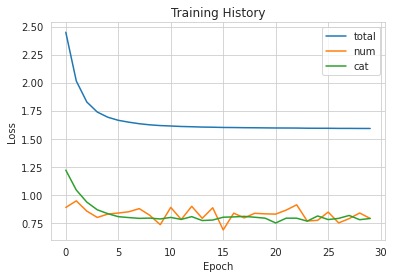

In [22]:
# Plot model loss/training progress
plt.plot(history.history['loss'])
plt.plot(history.history['loss_num'])
plt.plot(history.history['loss_cat'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","num","cat"], loc="upper right")
plt.show()

## Testing

In [23]:
# # Create model and load the best set of weights saved in the checkpoint folder (to avoid running training every time)
# checkpoint_filepath = './model_checkpoints/'
# rnn = RNN(lstm_model, CAT_IDX, CAT_LENGTHS)
# rnn.compile(optimizer=keras.optimizers.RMSprop(clipnorm=1.0))
# rnn.load_weights(checkpoint_filepath).expect_partial()  # Keep an eye on this; only weights are loaded could cause issues

In [24]:
# Generate n trip chains, each with MAXTIMESTEPS timesteps (each represents 1 day for 1 individual)
NUM_CHAINS = 100
result_chains = []

for i in range(NUM_CHAINS):
    # Get a random chain from the training data
    seed = train_data_x[int(np.random.rand(1)*10000),:,:]
    seed = np.reshape(seed, (1, MAX_TIMESTEPS, VAR_DIM))

    # After each prediction, add the prediction to the results and re-predict the remaining timesteps
    for j in range(1, MAX_TIMESTEPS):
        prediction = rnn.predict(seed)
        seed[:,j:,:] = prediction[:,j:,:]
    result_chains.append(seed)

In [25]:
# Get the data in the same dimensions as the input data
synthetic_chains = np.array(result_chains).reshape(NUM_CHAINS, MAX_TIMESTEPS, VAR_DIM)

# Assign a trip chain id to each synthetic chain
chain_ids = []

# Get np array of chain ids to append, must be same dims as the synthetic results
for i in range(NUM_CHAINS):
    to_add = np.zeros(MAX_TIMESTEPS) + i
    to_add = np.reshape(to_add, (MAX_TIMESTEPS, 1))
    chain_ids.append(to_add)
chain_ids = np.array(chain_ids)
synthetic_chains = np.append(synthetic_chains, chain_ids, axis=2).reshape((NUM_CHAINS*MAX_TIMESTEPS), VAR_DIM+1)

In [26]:
# Use inverse scaler to reverse the normalization for numerical variables
synthetic_chains[:,:CAT_IDX] = scaler_train.inverse_transform(synthetic_chains[:,:CAT_IDX])
results_df = pd.DataFrame(synthetic_chains[:,:CAT_IDX])

# Start the results df with the numerical vars
results_df = pd.DataFrame(synthetic_chains[:,:CAT_IDX])
train_df = pd.DataFrame(train_data_df.values[:,:CAT_IDX+1])

# Use argmax to reverse the ohe encoding for categorical variables, add them to the results df
cat_results = []
current = CAT_IDX
for i, var_length in enumerate(CAT_LENGTHS):
    result = np.argmax(synthetic_chains[:,current:current+var_length], axis=1)+1
    results_df[f'cat_var_{i}'] = result
    current = current+var_length
# Add back chainids
results_df.insert(0, 'CHAINID', synthetic_chains[:,-1])

# Repeat for test data
cat_results = []
current = CAT_IDX
for i, var_length in enumerate(CAT_LENGTHS):
    result = np.argmax(train_data_df.values[:,current:current+var_length], axis=1)+1
    train_df[f'cat_var_{i}'] = result
    current = current+var_length

# Give the variables their manifest names back and display
results_df.columns = VAR_NAMES
train_df.columns = VAR_NAMES

In [31]:
results_df

,CHAINID,STRTTIME,TRVLCMIN,TRPMILES,TDTRPNUM,TRAVDAY,TRPTRANS
0,0.0,1315.751703,26.193282,14.466997,1,1,1
1,0.0,1109.410738,25.720236,13.186699,1,6,3
2,0.0,887.667348,11.385126,13.473721,1,2,3
3,0.0,836.325380,-2.804164,13.186204,1,2,3
4,1.0,1315.751703,26.193282,14.466997,1,1,1
...,...,...,...,...,...,...,...
395,98.0,839.599032,0.597140,17.832080,1,2,6
396,99.0,1315.751703,26.193282,14.466997,1,1,1
397,99.0,1109.410738,25.720236,13.186699,1,6,3
398,99.0,855.975500,7.370020,14.202859,1,2,3


In [32]:
train_df

,CHAINID,STRTTIME,TRVLCMIN,TRPMILES,TDTRPNUM,TRAVDAY,TRPTRANS
0,46940.0,1115.0,15.0,8.017,1,6,7
1,46940.0,2330.0,10.0,8.017,1,6,7
2,13655.0,800.0,105.0,68.406,1,5,4
3,13655.0,1800.0,120.0,73.720,1,5,4
4,13656.0,700.0,15.0,0.688,2,5,2
...,...,...,...,...,...,...,...
194105,205134.0,1400.0,90.0,58.886,1,2,4
194106,205134.0,1600.0,30.0,18.004,1,2,4
194107,205134.0,2030.0,30.0,18.566,1,2,4
194108,144304.0,932.0,33.0,17.594,1,2,5


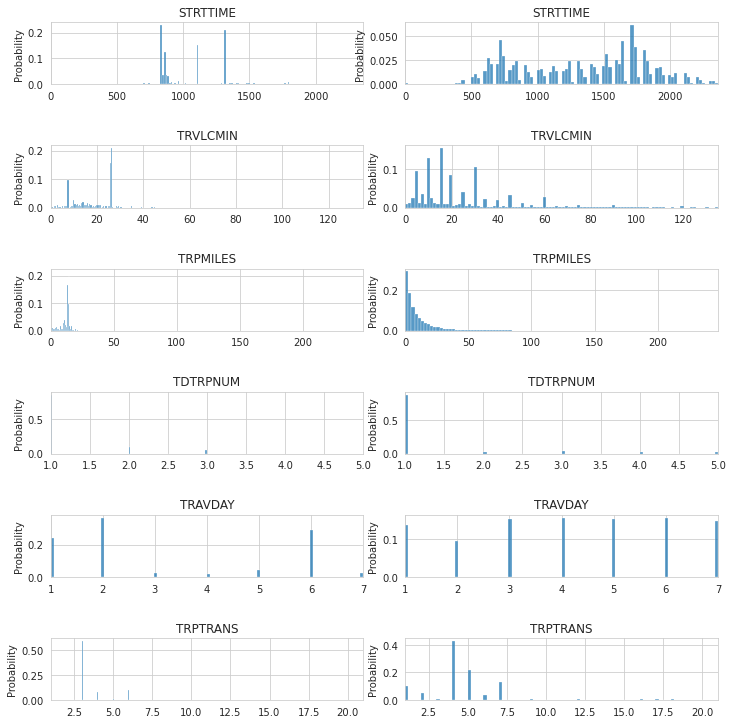

In [29]:
# Check the numerical variables for outliers
fig, axes = plt.subplots(nrows=len(VAR_NAMES)-1, ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, col in enumerate(VAR_NAMES[1:]):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(train_df[col]),max(train_df[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(train_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(train_df[col]),max(train_df[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)